In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile 
from pathlib import Path
import os
from tqdm import tqdm
import sys
import aligner as alg
sys.path.append('..')
from Onlypores import onlypores

# AUX

In [2]:
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)

# Load

In [19]:
filename = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\volume_eq')

data = read_sequence(filename)

# data = np.pad(data, ((10,10),(10,10),(10,10)), 'constant', constant_values=(38,38))

mask = onlypores.material_mask_parallel(data)

Progress: 100%|██████████| 3224/3224 [00:37<00:00, 85.32it/s]


computing otsu


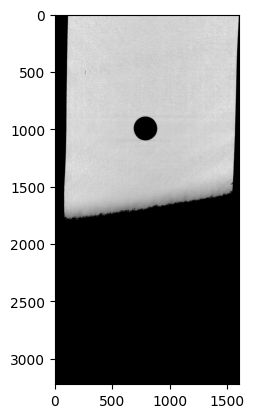

In [4]:
plt.imshow(data[:,:,30], cmap='gray')

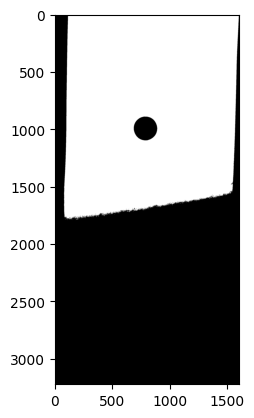

In [5]:
plt.imshow(mask[:,:,30], cmap='gray')

# CODE

In [6]:
import numpy as np
from scipy.ndimage import affine_transform, rotate
import matplotlib.pyplot as plt


In [7]:
def align_volume_xyz(volume,mask):
    """
    Aligns a binary object in a 3D volume with the array axes
    such that major, medium, minor object axes align with X, Y, Z array axes respectively.
    
    Args:
        volume (numpy.ndarray): Binary 3D volume with object labeled as 1
        
    Returns:
        numpy.ndarray: Aligned binary volume
    """
    # 1. Get object voxel coordinates more efficiently
    points_xyz = np.argwhere(mask)  # Implicit == 1 for non-zero values
    
    if points_xyz.shape[0] < 3:
        print("Not enough object points found for PCA.")
        return volume, mask
    
    # 2. Compute centroid and centered points
    centroid_xyz = points_xyz.mean(axis=0)
    centered_points_xyz = points_xyz - centroid_xyz
    
    # 3. Calculate covariance matrix and eigenvectors
    # Skip the full np.cov calculation and compute directly for performance
    n_points = centered_points_xyz.shape[0]
    cov_matrix_xyz = np.dot(centered_points_xyz.T, centered_points_xyz) / (n_points - 1)
    
    # Add regularization if needed
    if n_points <= 3:  # If number of points is small relative to dimensions
        cov_matrix_xyz += np.eye(3) * 1e-9
    
    # 4. Compute eigendecomposition (eigh is faster than eig for symmetric matrices)
    try:
        eigvals_xyz, eigvecs_xyz = np.linalg.eigh(cov_matrix_xyz)
    except np.linalg.LinAlgError:
        print("LinAlgError during eigendecomposition. Object might be too small or degenerate.")
        return volume, mask
    
    # 5. Sort eigenvectors by eigenvalue magnitude (descending)
    idx = eigvals_xyz.argsort()[::-1]
    eigvals_xyz = eigvals_xyz[idx]
    eigvecs_xyz = eigvecs_xyz[:, idx]
    
    # 6. Create transformation matrix directly without intermediate variables
    # Sort array dimensions by size
    array_dims = np.array(volume.shape)
    dims_idx = np.argsort(array_dims)[::-1]
    
    # Create transformation matrix
    matrix_candidate = np.zeros((3, 3))
    for i in range(3):
        matrix_candidate[:, dims_idx[i]] = eigvecs_xyz[:, i]
    
    # 7. Fix sign orientation (ensure positive diagonal)
    for i in range(3):
        if matrix_candidate[i, i] < 0:
            matrix_candidate[:, i] *= -1
    
    # 8. Ensure proper rotation matrix (det = 1)
    if np.linalg.det(matrix_candidate) < 0:
        matrix_candidate[:, dims_idx[2]] *= -1  # Flip the shortest dimension
    
    # 9. Calculate offset for centered transformation
    output_center_xyz = (np.array(volume.shape) - 1) / 2.0
    offset_vector = centroid_xyz - matrix_candidate @ output_center_xyz

    print('Transforming')
    
    # Apply transformation to the volume
    aligned_volume = affine_transform(
        volume.astype(float),
        matrix=matrix_candidate,
        offset=offset_vector,
        output_shape=volume.shape,
        order=3,  # Use nearest neighbor for binary data
        cval=0.0
    )
    
    return aligned_volume

In [8]:
aligned_volume = align_volume_xyz(data,mask)
aligned_mask = onlypores.material_mask_parallel(aligned_volume)

Transforming
computing otsu


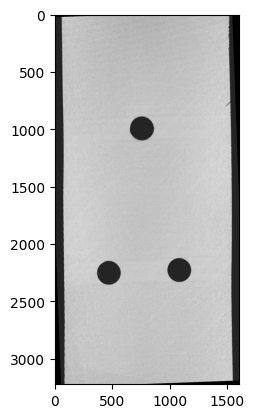

In [16]:
plt.imshow(aligned_volume[:,:,35], cmap='gray')

# detecting the first full mat slice

In [10]:
prueba = aligned_mask[:,:,:50]

We are going to measure the noise in the first 50 images of the mask volume, same with the number of pixels with value different to 0.

In [11]:
from skimage.restoration import estimate_sigma

def measure_noise_skimage(image):
    """
    Estimate noise standard deviation using skimage.
    
    Args:
        image (numpy.ndarray): Input image
        
    Returns:
        float: Estimated noise standard deviation
    """
    return estimate_sigma(image, average_sigmas=True)

def count_material(image):
    """
    Estimate noise standard deviation using skimage.
    
    Args:
        image (numpy.ndarray): Input image
        
    Returns:
        float: Estimated noise standard deviation
    """
    return np.count_nonzero(image) / image.size

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\alberto.vicente\.conda\envs\VisionPyKernel\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\alberto.vicente\.conda\envs\VisionPyKernel\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


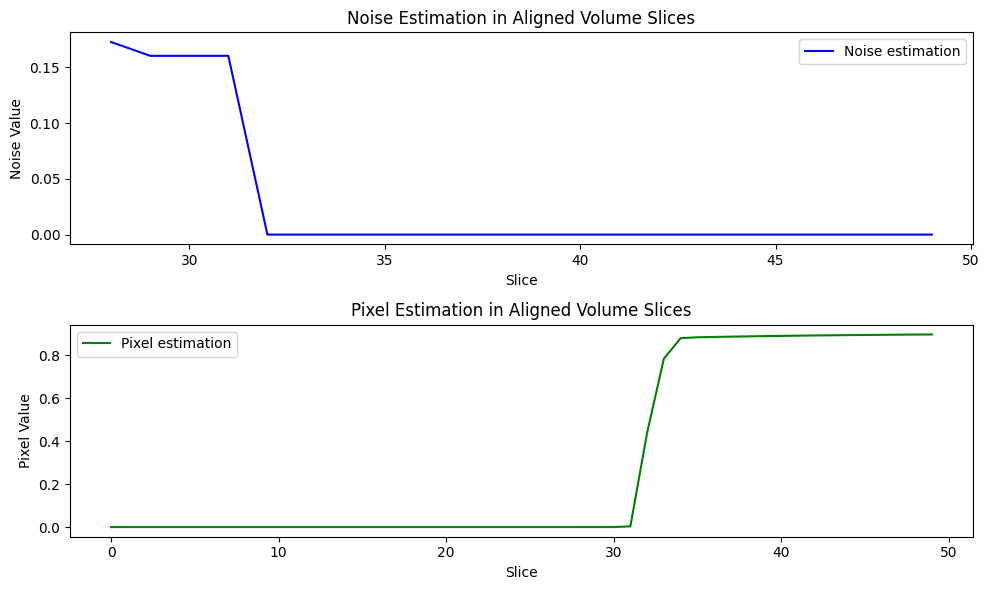

In [12]:
noise = np.zeros(prueba.shape[2])
for i in tqdm(range(prueba.shape[2])):
    noise[i] = measure_noise_skimage(prueba[:,:,i])

pixels = np.zeros(prueba.shape[2])
for i in tqdm(range(prueba.shape[2])):
    pixels[i] = count_material(prueba[:,:,i])

plt.figure(figsize=(10, 6))

# Plot noise
plt.subplot(2, 1, 1)
plt.plot(noise, label='Noise estimation', color='blue')
plt.xlabel('Slice')
plt.ylabel('Noise Value')
plt.title('Noise Estimation in Aligned Volume Slices')
plt.legend()

# Plot pixels
plt.subplot(2, 1, 2)
plt.plot(pixels, label='Pixel estimation', color='green')
plt.xlabel('Slice')
plt.ylabel('Pixel Value')
plt.title('Pixel Estimation in Aligned Volume Slices')
plt.legend()

plt.tight_layout()
plt.show()

We are goingo to find the flat line starting point.

The flat region begins at index: 37


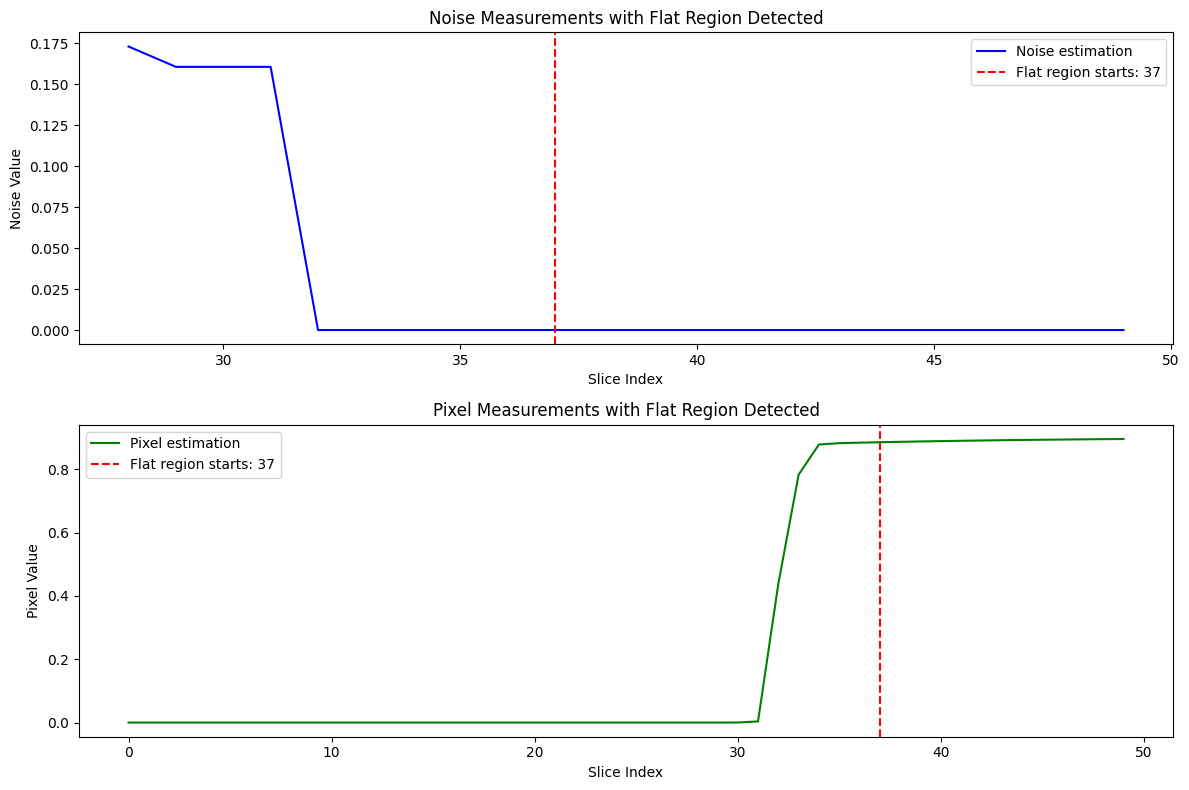

In [ ]:
import numpy as np

def find_flat_region_start(noise_values, pixels_values, window_size=5, threshold=0.01):
    """
    Find the index where a curve starts to flatten.
    
    Args:
        y_values: Array of y-values representing the function
        window_size: Size of the window to compute the gradient over
        threshold: Maximum gradient magnitude to consider as "flat"
        
    Returns:
        int: Index where the flat region begins
    """
    # Calculate rolling gradient
    noise_gradients = np.abs(np.gradient(noise_values))
    pixels_gradients = np.abs(np.gradient(pixels_values))
    
    # Apply moving average to smooth the gradients
    noise_smooth_gradients = np.convolve(noise_gradients, np.ones(window_size)/window_size, mode='valid')
    pixels_smooth_gradients = np.convolve(pixels_gradients, np.ones(window_size)/window_size, mode='valid')
    
    noise_index = -1
    pixels_index = -1

    # Find where gradient stays below threshold for the entire window
    for i in range(len(noise_smooth_gradients) - window_size + 1):
        if pixels_values[i] < 0.3:
            continue
        if np.all(noise_smooth_gradients[i:i+window_size] < threshold):
            noise_index = (i + window_size//2)
            break
    
    # Find where gradient stays below threshold for the entire window
    for i in range(len(pixels_smooth_gradients) - window_size + 1):
        if pixels_values[i] < 0.3:
            continue
        if np.all(pixels_smooth_gradients[i:i+window_size] < threshold):
            pixels_index = (i + window_size//2)
            break
    
    if noise_index >= 0 and pixels_index >= 0:
        # Return the first index where both conditions are met
        return max(noise_index, pixels_index)
    
    # If no flat region found
    return -1

# Apply to your noise data
flat_start_idx = find_flat_region_start(noise,pixels,5)
print(f"The flat region begins at index: {flat_start_idx}")

# Visualize both plots under the same figure
plt.figure(figsize=(12, 8))

# Plot noise
plt.subplot(2, 1, 1)
plt.plot(noise, label='Noise estimation', color='blue')
if flat_start_idx >= 0:
    plt.axvline(x=flat_start_idx, color='r', linestyle='--', label=f"Flat region starts: {flat_start_idx}")
plt.title("Noise Measurements with Flat Region Detected")
plt.xlabel("Slice Index")
plt.ylabel("Noise Value")
plt.legend()

# Plot pixels
plt.subplot(2, 1, 2)
plt.plot(pixels, label='Pixel estimation', color='green')
if flat_start_idx >= 0:
    plt.axvline(x=flat_start_idx, color='r', linestyle='--', label=f"Flat region starts: {flat_start_idx}")
plt.title("Pixel Measurements with Flat Region Detected")
plt.xlabel("Slice Index")
plt.ylabel("Pixel Value")
plt.legend()

plt.tight_layout()
plt.show()

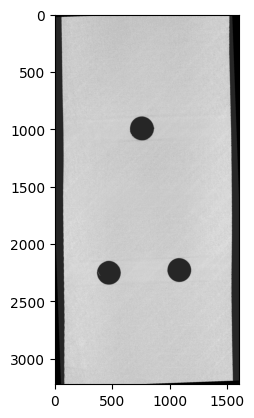

In [17]:
plt.imshow(aligned_volume[:,:,flat_start_idx], cmap='gray')

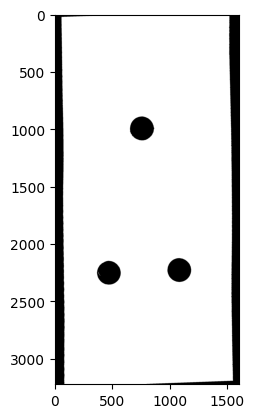

In [18]:
plt.imshow(aligned_mask[:,:,flat_start_idx], cmap='gray')